In [273]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import koreanize_matplotlib
from tensorflow.keras.utils import timeseries_dataset_from_array
import sys
sys.path.insert(1, '.')

In [274]:
import pandas as pd
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import numpy as np
from sklearn.metrics import mean_squared_error

In [275]:
df1 = pd.read_pickle('./data/data2.pkl')

In [276]:
col_len = 5
col_order = list(range(1, col_len))
col_order.extend([0])
col_order

[1, 2, 3, 4, 0]

In [277]:
df1 = df1.iloc[:, col_order]
df1

측정소명,영등포구,강서구,마포구,구로구,PM
일시,,,,,
2021-01-01 00:00:00,12.0,13.0,11.0,8.0,13.0
2021-01-01 05:00:00,9.0,12.0,10.0,12.0,13.0
2021-01-01 06:00:00,12.0,13.0,13.0,10.0,17.0
2021-01-01 07:00:00,14.0,13.0,13.0,11.0,15.0
2021-01-01 08:00:00,14.0,16.0,17.0,11.0,16.0
...,...,...,...,...,...
2023-09-18 04:00:00,17.0,15.0,12.0,13.0,14.0
2023-09-18 05:00:00,13.0,12.0,14.0,13.0,13.0
2023-09-18 06:00:00,10.0,13.0,14.0,8.0,13.0


In [278]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [279]:
df1

측정소명,영등포구,강서구,마포구,구로구,PM
일시,,,,,
2021-01-01 00:00:00,12.0,13.0,11.0,8.0,13.0
2021-01-01 05:00:00,9.0,12.0,10.0,12.0,13.0
2021-01-01 06:00:00,12.0,13.0,13.0,10.0,17.0
2021-01-01 07:00:00,14.0,13.0,13.0,11.0,15.0
2021-01-01 08:00:00,14.0,16.0,17.0,11.0,16.0
...,...,...,...,...,...
2023-09-18 04:00:00,17.0,15.0,12.0,13.0,14.0
2023-09-18 05:00:00,13.0,12.0,14.0,13.0,13.0
2023-09-18 06:00:00,10.0,13.0,14.0,8.0,13.0


In [280]:
df1.iloc[:,:-1].values, df1.iloc[:,[-1]].values

(array([[12., 13., 11.,  8.],
        [ 9., 12., 10., 12.],
        [12., 13., 13., 10.],
        ...,
        [10., 13., 14.,  8.],
        [ 9.,  6., 12.,  4.],
        [ 5.,  1., 10.,  2.]]),
 array([[13.],
        [13.],
        [17.],
        ...,
        [13.],
        [ 7.],
        [ 2.]]))

In [281]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1.iloc[:,:-1].values, df1.iloc[:,[-1]].values, test_size=0.2,shuffle=False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10808, 4) (10808, 1) (2702, 4) (2702, 1)


Convert the training data to tf.float32

In [282]:
scaled_X = scaler_X.fit_transform(X_train)
scaled_y = scaler_y.fit_transform(y_train)

data = tf.cast(scaled_X,tf.float32)
targets = tf.cast(scaled_y,tf.float32)

In [283]:
sample_len = 10
sequence_len = 1
batch_size = 256
input_len = col_len - 1

input_dataset = timeseries_dataset_from_array(data,None, sequence_length=sample_len,batch_size=batch_size, sequence_stride=sample_len)
target_dataset = timeseries_dataset_from_array(targets, None, sequence_length=sequence_len,batch_size=batch_size, sequence_stride=sample_len)

In [284]:
from transformers import Transformer

D_MODEL = 64
NUM_LAYERS = 8
NUM_HEADS= 8
DFF = 512

xformer = Transformer(1,num_layers=NUM_LAYERS,num_heads=NUM_HEADS,dff=DFF,d_model=D_MODEL)
pred = xformer(tf.random.normal((1,sample_len, input_len)),tf.random.normal((1,1,1)),False)
xformer.summary()

Model: "transformer_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_15 (Encoder)        multiple                  664384    
                                                                 
 decoder_15 (Decoder)        multiple                  798336    
                                                                 
 dense_2095 (Dense)          multiple                  65        
                                                                 
Total params: 1,462,785
Trainable params: 1,462,785
Non-trainable params: 0
_________________________________________________________________


In [285]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

In [286]:
len_data = sum(1 for _ in input_dataset)

In [287]:
epoch = 300
for e in range(epoch):
    for i,batch in enumerate(zip(input_dataset, target_dataset)):

        if i<len_data-1:
            in1, tar = batch
            
            tar_inp = tf.ones((batch_size,1,1))*-0.1
            tar_inp = tf.concat([tar_inp,tar[:, :-1]],axis=1)
            tar_real = tar
            with tf.GradientTape() as tape:
                predictions = xformer(in1, tar_inp,True)
                loss = tf.reduce_mean(tf.square(tar_real-predictions))
            gradients = tape.gradient(loss, xformer.trainable_variables)
            optimizer.apply_gradients(zip(gradients, xformer.trainable_variables))
                
    print(f"epoch {e}| Transformer:{loss.numpy()} ")

epoch 0| Transformer:0.7185116410255432 
epoch 1| Transformer:0.5101689100265503 
epoch 2| Transformer:0.41052091121673584 
epoch 3| Transformer:0.37362590432167053 
epoch 4| Transformer:0.4557797908782959 
epoch 5| Transformer:0.38247251510620117 
epoch 6| Transformer:0.3332202434539795 
epoch 7| Transformer:0.29841622710227966 
epoch 8| Transformer:0.2768704295158386 
epoch 9| Transformer:0.237417072057724 
epoch 10| Transformer:0.24623174965381622 
epoch 11| Transformer:0.21282118558883667 
epoch 12| Transformer:0.1818111538887024 
epoch 13| Transformer:0.17417916655540466 
epoch 14| Transformer:0.1771729439496994 
epoch 15| Transformer:0.17075438797473907 
epoch 16| Transformer:0.14312711358070374 
epoch 17| Transformer:0.12814833223819733 
epoch 18| Transformer:0.13297787308692932 
epoch 19| Transformer:0.13172394037246704 
epoch 20| Transformer:0.11446050554513931 
epoch 21| Transformer:0.10801104456186295 
epoch 22| Transformer:0.10458552837371826 
epoch 23| Transformer:0.106167

In [288]:
scaled_X = scaler_X.fit_transform(X_test)
x_test2 = timeseries_dataset_from_array(scaled_X, None, sequence_length=sample_len,batch_size=1, sequence_stride=sample_len)
y_test2 = timeseries_dataset_from_array(y_test, None, sequence_length=1,batch_size=1, sequence_stride=sample_len)
x_test2 = list(x_test2.as_numpy_iterator())
y_test2 = list(y_test2.as_numpy_iterator())

In [289]:
x_test3 = np.asarray(x_test2).reshape(-1,sample_len, input_len)
y_test3 = np.asarray(y_test2).reshape(-1,1,1)

In [290]:
def predict(inp):
    
    inp = inp.reshape(-1,sample_len,input_len)
    n_batch = inp.shape[0]
    start = np.ones((n_batch, 1, 1))*-0.1
    
    
    pred = xformer(inp, start, False)
    # pred = np.expand_dims(pred[:,-1,:], 0)
    # start = np.concatenate([start,pred], axis=1)
        
    # return start[:,1:]
    return pred

In [291]:
preds_xform = [predict(x) for x in x_test2]
preds_xform = scaler_y.inverse_transform(np.array(preds_xform).reshape(-1, 1))
err_xform = np.mean([(y_true-y_pred)**2 for y_true,y_pred in zip(y_test2,preds_xform)])

In [292]:
def plot(data, y_predict_test):
    plt.plot(data[:, [-1]].flatten(), label='실제 PM2.5')

    plt.plot(y_predict_test.flatten(), label='Test 데이터 예측 PM2.5')

    plt.legend()
    plt.show()

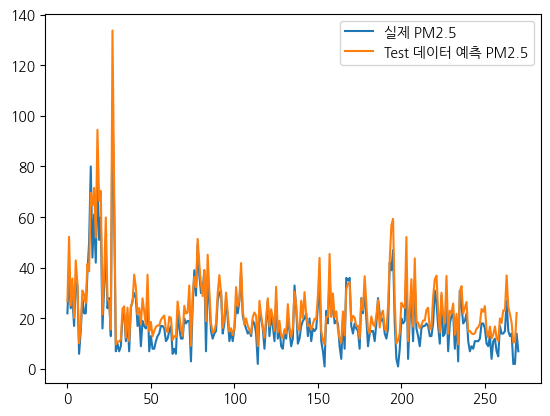

In [293]:
plot(y_test3, preds_xform)

In [294]:
err_xform

36.52173260440171

In [295]:
# D_MODEL = 64, NUM_LAYERS = 4, NUM_HEADS = 4 -> 22.635039013770626
# D_MODEL = 32, NUM_LAYERS = 1, NUM_HEADS = 4 -> 30.619284479204357
# D_MODEL = 32, NUM_LAYERS = 4, NUM_HEADS = 8 -> 29.241474142342042
# D_MODEL = 32, NUM_LAYERS = 4, NUM_HEADS = 8 -> 16.19200500098079
# D_MODEL = 64, NUM_LAYERS = 4, NUM_HEADS = 8 -> 14.601263697129243